In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *
import torchvision.models as tmodels

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.misc import imsave

from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.misc import imsave


from imageio import imread

import os
import sys

sys.path.insert(0, '/home/santhosr/Documents/Birad/FastAI/RaceClassification/' )

from utils import *

from birad.blackbox import getRatio, analyzeFeature, plotImageFFT, getImageFFT
from birad import *


In [2]:
inputFolder1 = '/home/santhosr/Documents/Birad/ProcessedData/FullRes'
truthFile1 = '/home/santhosr/Documents/Birad/birad_targetFile.csv'

inputFolder2 = '/home/santhosr/Documents/Birad/ProcessedData/PennExtra_3500/'
truthFile2 = '/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv'

df1 = pd.read_csv('/home/santhosr/Documents/Birad/birad_targetFile.csv')
df1.drop(['PresIntentType','DBT'],inplace = True,axis=1)
df1['FolderLocation'] =  inputFolder1

folderFileList1 = []
for i in range(1,5):
        folder = os.path.join(inputFolder1,str(i))
        fileList = os.listdir(folder)
        folderFileList1 += fileList
        
folderFileList1 = set(folderFileList1)

folderFileList2 = set(os.listdir(inputFolder2))


df2 = pd.read_csv('/home/santhosr/Documents/Birad/RaceDL_ExtraCaucasian.csv')
df2.Medview_Race = 'White'
df2['FolderLocation'] =  inputFolder2
truth = pd.concat([df1,df2],sort=True)

In [3]:

setTruthFile(truth)

truth.head()

,Age,BMI,Density_Overall,DummyID,FolderLocation,Medview_Race,ScreenDate
0,67.8,27.1,2.0,2508626,/home/santhosr/Documents/Birad/ProcessedData/F...,White,3/23/2011
1,58.8,25.7,2.0,2505738,/home/santhosr/Documents/Birad/ProcessedData/F...,White,6/2/2011
2,56.4,28.1,2.0,2547962,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/24/2011
3,51.7,31.8,2.0,2575490,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/6/2011
4,63.7,27.5,2.0,2591080,/home/santhosr/Documents/Birad/ProcessedData/F...,Other,5/5/2011


In [4]:
dfFile = "/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/DataFile9.csv"

modelName = 'model_resnet50_id9_acc848_loss376'


#Feature Directories
trainFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/Features/model9_1/train'

validFolder = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/withLargerDataset/Features/model9_1/valid'

In [5]:
df = pd.read_csv(dfFile)

df.head()

,DummyID,filename,train
0,75218338,FullRes/3/75218338_R_CC_1.jpg,True
1,75145018,FullRes/2/75145018_R_MLO_1.jpg,True
2,75913007,PennExtra_3500/75913007_FOR-PROCESSING_L_CC_1.jpg,False
3,4632661,FullRes/2/4632661_R_CC_1.jpg,True
4,4011669,PennExtra_3500/4011669_FOR-PROCESSING_R_CC_1.jpg,False


In [6]:
trainFeatureList = []

fileList = os.listdir(trainFolder)

for file in fileList:
    name= file[:-4]
    
    data = np.load(os.path.join(trainFolder,file))
    
    trainFeatureList.append([name]+list(data[0]))
    
df= pd.DataFrame(trainFeatureList)

df.columns = ['filename'] + list(df.columns[1:])

In [7]:
df.head()

,filename,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,75432702_FOR-PROCESSING_L_CC_1,0.318464,-0.868129,1.271608,-1.633337,2.322261,0.805958,0.365415,2.305241,0.340661,...,0.125331,0.533862,2.120199,1.055852,0.619647,-1.389453,-0.122542,0.774450,-1.069403,0.973135
1,76172010_FOR-PROCESSING_R_CC_1,-0.682959,-0.849172,-0.659703,-1.903092,-0.231207,1.501490,-1.102302,-0.775881,-0.341252,...,0.015796,-0.149194,-0.485364,-0.574554,-1.243969,-0.153757,1.032761,0.067956,-0.267267,0.111444
2,3598763_FOR-PROCESSING_R_CC_1,-0.477616,-0.884910,-0.320784,-1.688989,0.071879,0.861444,-0.514763,-0.654355,0.175667,...,-0.362173,0.020006,-0.637149,-0.511435,-1.471525,-0.617466,-0.087241,-1.532474,-0.133385,0.732797
3,5285183_L_MLO_1,0.637182,-0.804549,0.622584,-0.403377,0.096624,1.030809,0.631088,0.458424,-1.333583,...,0.127030,1.064507,-0.100067,0.187556,0.789110,-0.215629,0.812649,0.044867,-0.404423,0.037524
4,75216411_L_CC_1,0.123420,0.375297,0.269578,1.081226,0.585032,1.852086,-0.210149,-0.675425,-0.681569,...,0.267990,-0.482677,0.091323,-0.217181,-0.357957,1.083545,1.099478,-0.036684,-0.090892,0.591378


In [8]:
validFeatureList = []

fileList = os.listdir(validFolder)

for file in fileList:
    name= file[:-4]
    
    data = np.load(os.path.join(validFolder,file))
    
    validFeatureList.append([name]+list(data[0]))
    
validdf= pd.DataFrame(validFeatureList)

validdf.columns = ['filename'] + list(validdf.columns[1:])

In [9]:
validdf.head()

,filename,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,76931196_FOR-PROCESSING_R_CC_1,-1.231512,0.369072,0.196341,-0.929545,-0.509406,2.731149,-0.860410,-0.321242,-0.538691,...,0.890818,-0.702161,0.867556,-0.406007,0.126185,-0.156691,1.795073,-0.065911,-0.204034,-0.252097
1,3777048_FOR-PROCESSING_R_CC_1,-1.042962,0.286782,-0.649373,-0.830330,-0.043238,1.810513,-0.639293,-0.454372,0.097095,...,-0.190131,-0.624011,0.471497,-0.335744,-1.818393,0.076566,0.747977,-0.952192,-0.077268,-0.617548
2,75848706_L_CC_1,-0.763697,-0.198883,-0.384826,0.282416,0.477754,1.144091,0.849824,-0.784560,-0.616457,...,-0.521382,-0.900622,1.155248,-0.531448,-0.873260,0.221730,0.367012,-0.081955,-0.156594,-0.108223
3,75223618_FOR-PROCESSING_L_MLO_1,-0.769130,-1.259268,1.470886,-1.291417,1.230018,0.147608,-0.563705,1.268680,0.522559,...,0.216351,0.170085,3.194001,0.446780,-1.201430,0.307178,1.601178,-0.021837,-0.286524,1.481083
4,5296539_L_MLO_1,0.048194,-0.797688,0.113589,1.162040,-1.441450,-1.061866,0.781506,-0.017739,0.250927,...,0.527766,0.668696,0.774518,0.120136,0.689082,-0.543824,-1.455966,0.442612,0.112919,-0.876768


### Random Testing

In [6]:
# plt.figure(figsize=(10,10))
analyzeFeature(df, truth, 2,1000, (15,15), createPlots=False)

Race - White 0.74 | Side - R 0.17  | View - CC 0.54 


(0.74, 0.17, 0.54)

In [8]:
# plt.figure(figsize=(10,10))
analyzeFeature(df,truth,6,2000, (15,15), createPlots=False)

Race - White 0.01 | Side - R 0.52  | View - CC 0.15 


(0.01, 0.52, 0.15)

In [110]:
img = imread(imageFileList[4])

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Race - White 0 | Side - R 0.8  | View - CC 0 


(0, 0.8, 0)

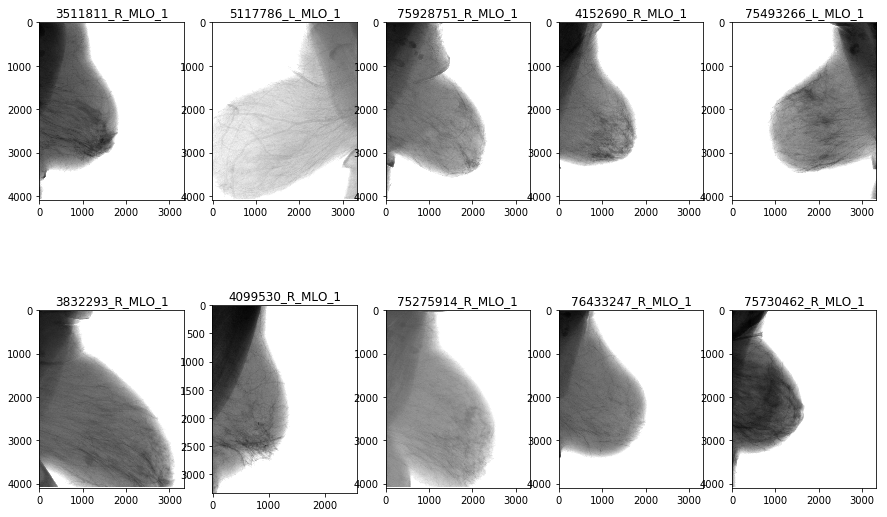

In [7]:
# plt.figure(figsize=(10,10))
analyzeFeature(df,truth,6,10, (15,15), createPlots=True)

### Generating All Feature Statistics

In [8]:
statList = []

for i in range(512):
    
    out = analyzeFeature(df,truth, i+1,1000, (15,15), createPlots=False)
    statList.append([i+1,*out])
    
statListDf = pd.DataFrame(statList)
statListDf.columns = ['feature','whiteRatio','rightRatio','CCRatio']    

Race - White 0.66 | Side - R 0.33  | View - CC 0.05 
Race - White 0.19 | Side - R 0.5  | View - CC 0.84 
Race - White 0.99 | Side - R 0.37  | View - CC 0.0 
Race - White 0.01 | Side - R 0.48  | View - CC 0.98 
Race - White 0.99 | Side - R 0.22  | View - CC 0.4 
Race - White 0.86 | Side - R 0.42  | View - CC 0.89 
Race - White 0.99 | Side - R 0.39  | View - CC 0.01 
Race - White 1.0 | Side - R 0.48  | View - CC 0.01 
Race - White 0.76 | Side - R 0.39  | View - CC 0.24 
Race - White 0.02 | Side - R 0.08  | View - CC 0.21 
Race - White 0.2 | Side - R 0.27  | View - CC 0.07 
Race - White 0.03 | Side - R 0.35  | View - CC 0.5 
Race - White 0.78 | Side - R 0.48  | View - CC 0.05 
Race - White 0.99 | Side - R 0.53  | View - CC 0.02 
Race - White 0.99 | Side - R 0.45  | View - CC 0.02 
Race - White 0.8 | Side - R 0.53  | View - CC 0.02 
Race - White 0.91 | Side - R 0.48  | View - CC 0.62 
Race - White 0.95 | Side - R 0.4  | View - CC 0.97 
Race - White 0.39 | Side - R 0.72  | View - CC 0.0 
Ra

Race - White 0.06 | Side - R 0.13  | View - CC 0.16 
Race - White 0.07 | Side - R 0.51  | View - CC 0.13 
Race - White 0.99 | Side - R 0.19  | View - CC 0.08 
Race - White 0.95 | Side - R 0.4  | View - CC 0.04 
Race - White 0.28 | Side - R 0.42  | View - CC 0.29 
Race - White 0.99 | Side - R 0.11  | View - CC 0.37 
Race - White 0.49 | Side - R 0.53  | View - CC 0.08 
Race - White 0.98 | Side - R 0.51  | View - CC 0.34 
Race - White 0.02 | Side - R 0.45  | View - CC 0.85 
Race - White 0.98 | Side - R 0.56  | View - CC 0.0 
Race - White 0.99 | Side - R 0.4  | View - CC 0.02 
Race - White 0.69 | Side - R 0.9  | View - CC 0.92 
Race - White 0.56 | Side - R 0.42  | View - CC 0.02 
Race - White 0.87 | Side - R 0.31  | View - CC 0.96 
Race - White 0.95 | Side - R 0.14  | View - CC 0.3 
Race - White 0.99 | Side - R 0.36  | View - CC 0.01 
Race - White 0.28 | Side - R 0.37  | View - CC 0.57 
Race - White 0.0 | Side - R 0.35  | View - CC 0.53 
Race - White 1.0 | Side - R 0.42  | View - CC 0.1 
R

Race - White 0.55 | Side - R 0.2  | View - CC 0.02 
Race - White 0.99 | Side - R 0.34  | View - CC 0.04 
Race - White 0.01 | Side - R 0.43  | View - CC 0.62 
Race - White 0.65 | Side - R 0.81  | View - CC 0.12 
Race - White 0.99 | Side - R 0.67  | View - CC 0.05 
Race - White 0.01 | Side - R 0.8  | View - CC 0.02 
Race - White 0.96 | Side - R 0.62  | View - CC 0.79 
Race - White 1.0 | Side - R 0.38  | View - CC 0.03 
Race - White 0.01 | Side - R 0.23  | View - CC 0.17 
Race - White 0.97 | Side - R 0.52  | View - CC 0.16 
Race - White 0.99 | Side - R 0.51  | View - CC 0.25 
Race - White 0.36 | Side - R 0.37  | View - CC 0.04 
Race - White 0.99 | Side - R 0.34  | View - CC 0.0 
Race - White 0.18 | Side - R 0.26  | View - CC 0.61 
Race - White 0.53 | Side - R 0.57  | View - CC 0.43 
Race - White 0.99 | Side - R 0.41  | View - CC 0.01 
Race - White 1.0 | Side - R 0.43  | View - CC 0.42 
Race - White 0.98 | Side - R 0.74  | View - CC 0.43 
Race - White 0.01 | Side - R 0.41  | View - CC 0.01

Race - White 0.93 | Side - R 0.59  | View - CC 0.28 
Race - White 0.03 | Side - R 0.38  | View - CC 0.34 
Race - White 1.0 | Side - R 0.43  | View - CC 0.55 
Race - White 0.03 | Side - R 0.35  | View - CC 0.05 
Race - White 0.08 | Side - R 0.18  | View - CC 0.31 
Race - White 0.01 | Side - R 0.4  | View - CC 0.62 
Race - White 0.99 | Side - R 0.81  | View - CC 0.32 
Race - White 0.99 | Side - R 0.98  | View - CC 0.49 
Race - White 0.01 | Side - R 0.63  | View - CC 0.01 
Race - White 0.71 | Side - R 0.08  | View - CC 0.09 
Race - White 0.99 | Side - R 0.42  | View - CC 0.01 
Race - White 0.99 | Side - R 0.62  | View - CC 0.03 
Race - White 0.04 | Side - R 0.54  | View - CC 0.29 
Race - White 0.77 | Side - R 0.51  | View - CC 0.35 
Race - White 0.99 | Side - R 0.5  | View - CC 0.02 
Race - White 0.99 | Side - R 0.38  | View - CC 0.01 
Race - White 0.04 | Side - R 0.88  | View - CC 0.16 
Race - White 0.52 | Side - R 0.28  | View - CC 0.23 
Race - White 0.99 | Side - R 0.45  | View - CC 0.

In [9]:

statListDf.head()

,feature,whiteRatio,rightRatio,CCRatio
0,1,0.66,0.33,0.05
1,2,0.19,0.50,0.84
2,3,0.99,0.37,0.00
3,4,0.01,0.48,0.98
4,5,0.99,0.22,0.40


In [10]:
statListDf.sort_values('whiteRatio',ascending=True).head()

,feature,whiteRatio,rightRatio,CCRatio
197,198,0.0,0.73,0.02
264,265,0.0,0.63,0.83
36,37,0.0,0.45,0.49
265,266,0.0,0.19,0.08
269,270,0.0,0.33,0.07


In [11]:
statListDf.sort_values('whiteRatio',ascending=False).head()

,feature,whiteRatio,rightRatio,CCRatio
191,192,1.0,0.40,0.17
38,39,1.0,0.48,0.08
248,249,1.0,0.43,0.01
359,360,1.0,0.49,0.13
127,128,1.0,0.38,0.03


Race - White 0 | Side - R 0.9  | View - CC 0 


(0, 0.9, 0)

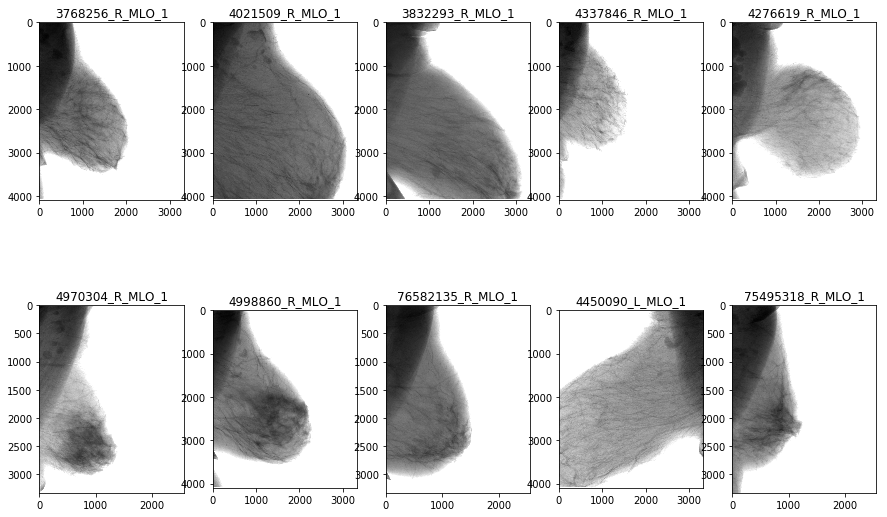

In [14]:
analyzeFeature(df,truth,198,10, (15,15), createPlots=True)

Race - White 0 | Side - R 0.5  | View - CC 1.0 


(0, 0.5, 1.0)

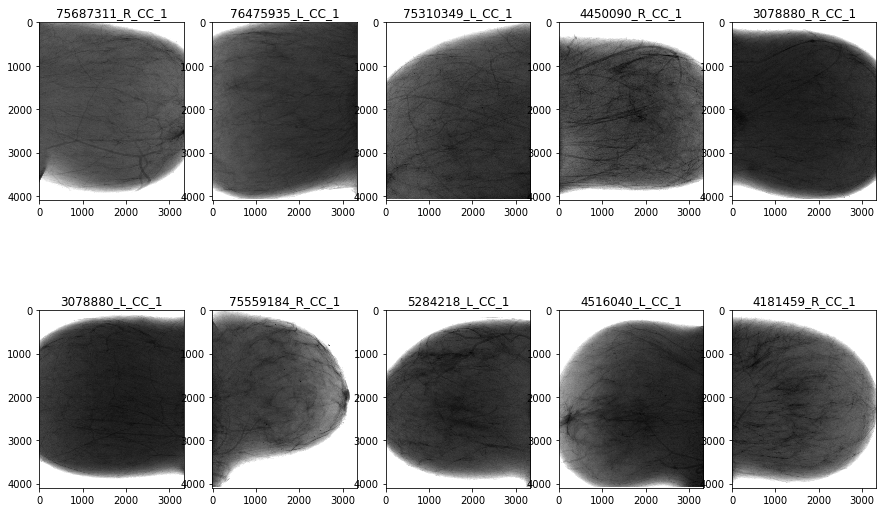

In [15]:
analyzeFeature(df,truth,265,10, (15,15), createPlots=True)

Race - White 0 | Side - R 0.6  | View - CC 0.1 


(0, 0.6, 0.1)

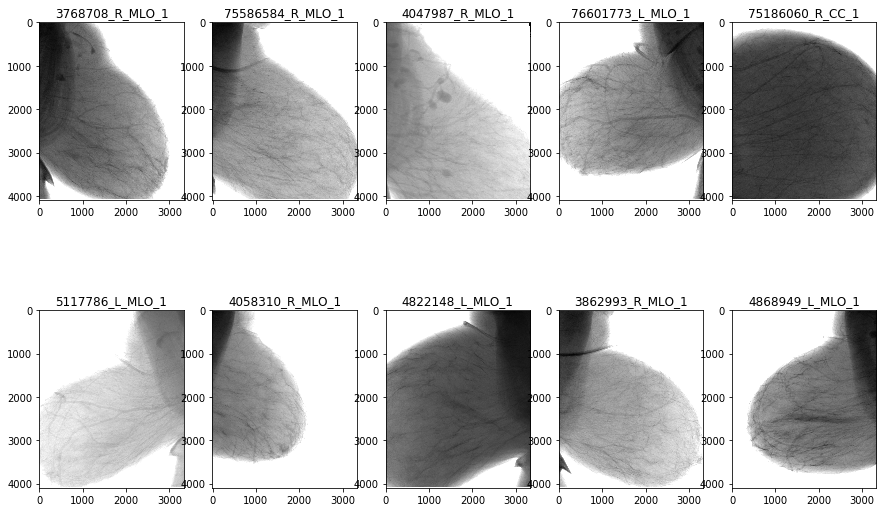

In [11]:
# plt.figure(figsize=(10,10))
analyzeFeature(df,truth,122,10, (15,15), createPlots=True)

Race - White 1.0 | Side - R 0.4  | View - CC 0 


(1.0, 0.4, 0)

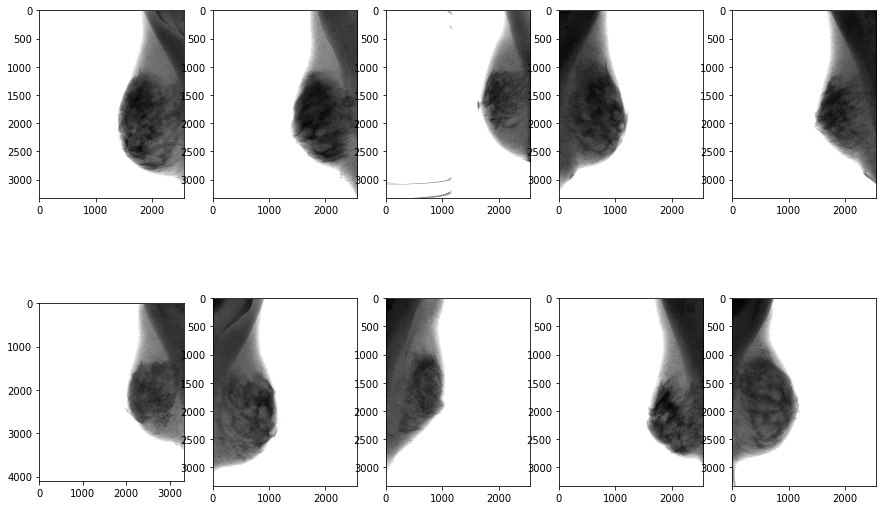

In [21]:
# plt.figure(figsize=(10,10))
analyzeFeature(df,truth,81,10, (15,15), createPlots=True)

Race - White 1.0 | Side - R 0.5  | View - CC 0 


(1.0, 0.5, 0)

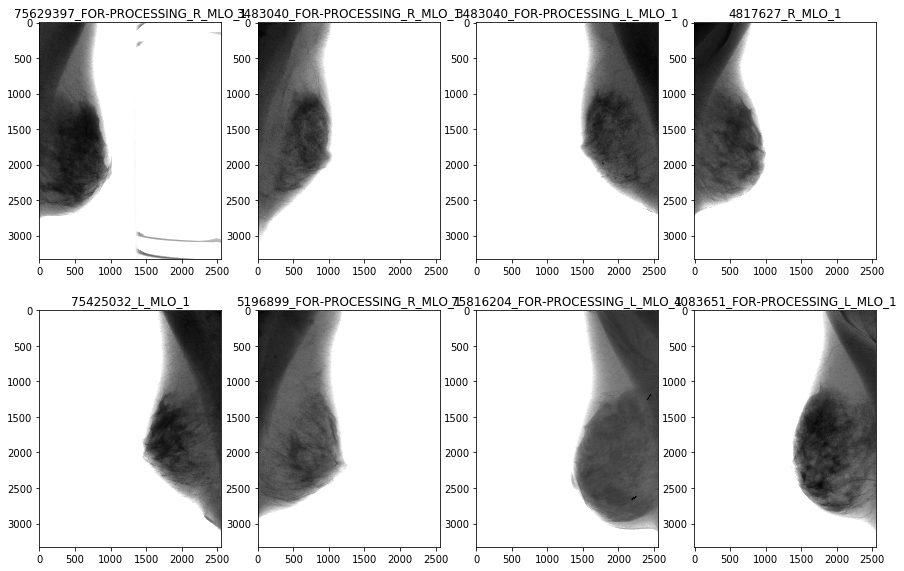

In [14]:
# plt.figure(figsize=(10,10))
analyzeFeature(df,truth,79,8, (15,15), createPlots=True,numCols=4)

In [25]:
df.head()

,filename,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,76931196_FOR-PROCESSING_R_CC_1,-1.115904,-0.136921,-0.918377,-1.319869,1.200679,-0.774591,-1.223394,-0.866892,-1.605233,...,-0.919160,0.374188,-1.396658,0.673017,0.643678,0.494869,-0.522402,0.917830,-0.904028,0.548930
1,75432702_FOR-PROCESSING_L_CC_1,0.837221,1.266940,0.866333,-1.485773,0.544732,-0.978558,-1.113917,-1.669239,-0.880934,...,-0.167124,1.029974,0.210396,0.172296,0.684554,-0.255956,-1.928500,0.327528,-0.511521,1.473753
2,3598763_FOR-PROCESSING_R_CC_1,0.046063,0.388634,0.310408,-0.058115,0.288248,-0.941180,-0.771776,0.377676,-0.500767,...,0.341179,1.047236,-0.429822,-0.983415,-0.738943,0.765579,-1.676381,0.592785,-0.871576,1.664883
3,5285183_L_MLO_1,0.970459,0.851966,0.796446,0.999039,-1.328429,2.191711,0.388034,0.635104,0.870009,...,0.733652,-1.447253,-0.468189,1.170216,-0.281562,-0.327807,2.361926,-0.793292,1.589953,-3.335149
4,75216411_L_CC_1,-0.364582,-0.454646,0.416625,1.311783,0.742327,-0.760245,-1.614056,-0.885158,0.521710,...,-0.576747,-0.603860,-1.758441,1.424496,0.099586,0.069841,0.100994,-0.801616,0.001879,0.278086


In [27]:
df[[81,512,341,79,216]].corr()

,81,512,341,79,216
81,1.000000,0.826497,0.873397,0.656712,0.794368
512,0.826497,1.000000,0.809457,0.672409,0.816494
341,0.873397,0.809457,1.000000,0.691300,0.844762
79,0.656712,0.672409,0.691300,1.000000,0.683008
216,0.794368,0.816494,0.844762,0.683008,1.000000


In [11]:
# plt.figure(figsize=(10,10))
analyzeFeature(validdf,truth,192,100, (15,15), createPlots=False)

Race - White 1.0 | Side - R 0.47  | View - CC 0.04 


(1.0, 0.47, 0.04)

In [12]:
len(validdf)

8000

In [13]:
truth

,Age,BMI,Density_Overall,DummyID,FolderLocation,Medview_Race,ScreenDate
0,67.8,27.1,2.0,2508626,/home/santhosr/Documents/Birad/ProcessedData/F...,White,3/23/2011
1,58.8,25.7,2.0,2505738,/home/santhosr/Documents/Birad/ProcessedData/F...,White,6/2/2011
2,56.4,28.1,2.0,2547962,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/24/2011
3,51.7,31.8,2.0,2575490,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/6/2011
4,63.7,27.5,2.0,2591080,/home/santhosr/Documents/Birad/ProcessedData/F...,Other,5/5/2011
5,75.7,31.7,3.0,2591153,/home/santhosr/Documents/Birad/ProcessedData/F...,White,4/22/2011
6,57.4,23.7,3.0,2608662,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/10/2011
7,59.2,31.1,2.0,2708153,/home/santhosr/Documents/Birad/ProcessedData/F...,White,6/7/2011
8,74.7,30.8,2.0,2734158,/home/santhosr/Documents/Birad/ProcessedData/F...,African American,6/23/2011
9,77.8,30.6,2.0,2839720,/home/santhosr/Documents/Birad/ProcessedData/F...,African American,9/23/2010


### Analysing based on BreastDensityArea

In [9]:
def printFileList(fileList):
    
    imageFileList = []
    
    for i in range(len(fileList)):

        filename = fileList[i] + '.jpg'

        imageFileList.append(getFileLocation(filename))

    plt.figure(figsize=(20,10))

    for j in range(5):


        plt.subplot(1, 5, j+1)
        img = imread(imageFileList[j])
        plt.title(imageFileList[j].split("/")[-1].split(".")[0])
        plt.imshow(img, 'gray')

In [10]:
truthFile = '/home/santhosr/Documents/Birad/FastAI/RaceClassification/Final.csv'
temp = pd.read_csv(truthFile)

keepList = ['ImageName','VolumetricBreastDensity','DenseAreaPercent']
temp = temp[keepList] 

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
temp.columns = ['filename','VolumetricBreastDensity','DenseAreaPercent']
temp.head()

,filename,VolumetricBreastDensity,DenseAreaPercent
0,2036311_L_CC_1,5.2457,67.1112
1,2036311_L_MLO_1,10.5883,92.3699
2,2036311_L_MLO_2,5.1084,55.4036
3,2036311_R_CC_1,4.6236,39.2641
4,2036311_R_MLO_1,7.1716,85.2747


#### Feature 198 | All African American

In [12]:
a = analyzeFeature(df,truth,198,250, (15,15), createPlots=False,return_df=True)

Race - White 0.0 | Side - R 0.78  | View - CC 0.0 


In [13]:
a.head()

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall
0,3768256_R_MLO_1,8.757934,3768256,R,MLO,African American,2.0
1,4021509_R_MLO_1,8.630558,4021509,R,MLO,African American,2.0
2,3832293_R_MLO_1,8.497263,3832293,R,MLO,African American,2.0
3,4337846_R_MLO_1,8.043472,4337846,R,MLO,African American,2.0
4,4276619_R_MLO_1,8.008749,4276619,R,MLO,African American,2.0


In [14]:
a = a.merge(temp, on='filename',how='left')

In [15]:
truth.head()

,Age,BMI,Density_Overall,DummyID,FolderLocation,Medview_Race,ScreenDate
0,67.8,27.1,2.0,2508626,/home/santhosr/Documents/Birad/ProcessedData/F...,White,3/23/2011
1,58.8,25.7,2.0,2505738,/home/santhosr/Documents/Birad/ProcessedData/F...,White,6/2/2011
2,56.4,28.1,2.0,2547962,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/24/2011
3,51.7,31.8,2.0,2575490,/home/santhosr/Documents/Birad/ProcessedData/F...,White,5/6/2011
4,63.7,27.5,2.0,2591080,/home/santhosr/Documents/Birad/ProcessedData/F...,Other,5/5/2011


In [16]:
a = pd.merge(a, truth[['DummyID','BMI']], on='DummyID',how='left')

In [17]:
a.DenseAreaPercent.describe()

count    237.000000
mean      37.225316
std        7.571503
min       23.500000
25%       31.800000
50%       36.000000
75%       41.700000
max       72.600000
Name: BMI, dtype: float64

In [42]:
a[a.DenseAreaPercent<21][:5]

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
1,4021509_R_MLO_1,8.630558,4021509,R,MLO,African American,2.0,4.4200,8.09352
11,75340314_R_MLO_1,7.597609,75340314,R,MLO,African American,2.0,3.0345,14.31920
21,3413823_R_MLO_1,7.254880,3413823,R,MLO,African American,2.0,2.7520,10.97590
28,75258649_R_MLO_1,7.152415,75258649,R,MLO,African American,2.0,3.1928,19.84600
34,75260214_L_MLO_1,7.048492,75260214,L,MLO,African American,1.0,3.1115,10.89600


In [43]:
a[a.DenseAreaPercent>58][:5]

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
0,3768256_R_MLO_1,8.757934,3768256,R,MLO,African American,2.0,7.8008,67.5837
5,4970304_R_MLO_1,7.826849,4970304,R,MLO,African American,2.0,9.2228,66.1688
9,75495318_R_MLO_1,7.696643,75495318,R,MLO,African American,2.0,8.3963,77.0421
18,4787356_R_MLO_1,7.321577,4787356,R,MLO,African American,2.0,7.0993,66.4518
22,75156350_R_MLO_1,7.229428,75156350,R,MLO,African American,3.0,13.7753,71.2900


In [40]:
a[a.DenseAreaPercent<21][:5]['filename'].values

array(['4021509_R_MLO_1', '75340314_R_MLO_1', '3413823_R_MLO_1', '75258649_R_MLO_1', '75260214_L_MLO_1'], dtype=object)

In [41]:
a[a.DenseAreaPercent>58][:5]['filename'].values

array(['3768256_R_MLO_1', '4970304_R_MLO_1', '75495318_R_MLO_1', '4787356_R_MLO_1', '75156350_R_MLO_1'], dtype=object)

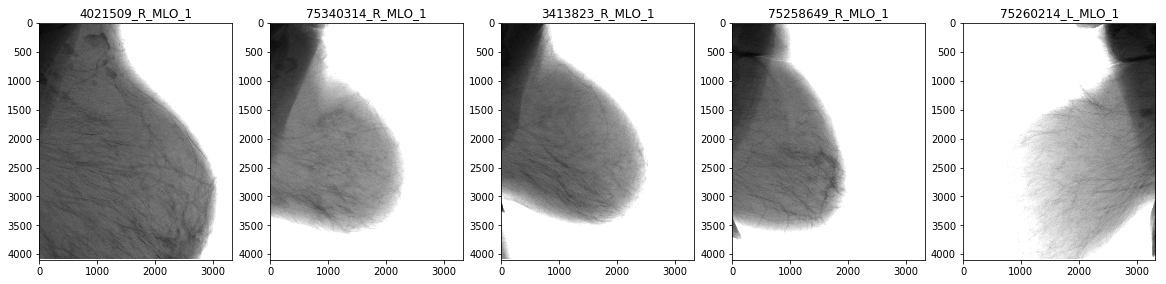

In [54]:
printFileList(list(a[a.DenseAreaPercent<21][:5]['filename'].values))

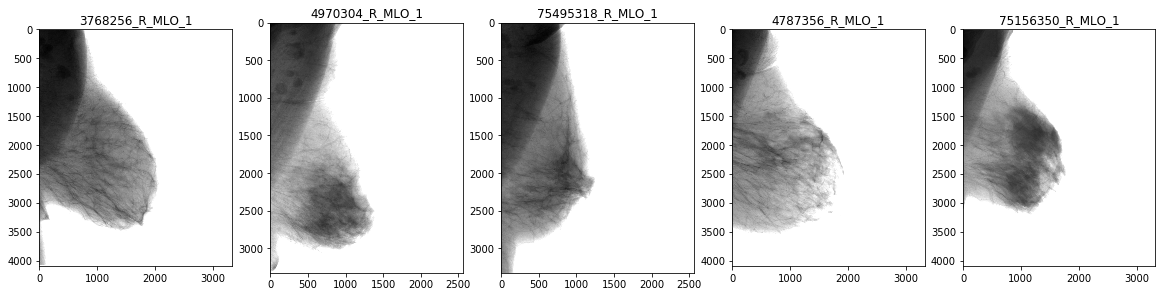

In [53]:
printFileList(list(a[a.DenseAreaPercent>58][:5]['filename'].values))

In [19]:
a = analyzeFeature(df,truth,198,1000, (15,15), createPlots=False,return_df=True)

a = a.merge(temp, on='filename',how='left')

Race - White 0.0 | Side - R 0.73  | View - CC 0.02 


In [20]:
a = a[~pd.isna(a.DenseAreaPercent)]

print(len(a))

904


In [21]:

np.corrcoef(a[198].values, a.DenseAreaPercent)

array([[1.      , 0.013138],
       [0.013138, 1.      ]])

In [22]:
a.head()

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
0,3768256_R_MLO_1,8.757934,3768256,R,MLO,African American,2.0,7.8008,67.58370
1,4021509_R_MLO_1,8.630558,4021509,R,MLO,African American,2.0,4.4200,8.09352
3,4337846_R_MLO_1,8.043472,4337846,R,MLO,African American,2.0,6.9252,57.15740
4,4276619_R_MLO_1,8.008749,4276619,R,MLO,African American,2.0,6.2010,38.06050
5,4970304_R_MLO_1,7.826849,4970304,R,MLO,African American,2.0,9.2228,66.16880


In [24]:
a = pd.merge(a, truth, on='DummyID',how='left')

a = a[~pd.isna(a.BMI)]

In [28]:

np.corrcoef(a[198].values, a.BMI)

array([[1.      , 0.091931],
       [0.091931, 1.      ]])

In [18]:
a.BMI.describe()

count    237.000000
mean      37.225316
std        7.571503
min       23.500000
25%       31.800000
50%       36.000000
75%       41.700000
max       72.600000
Name: BMI, dtype: float64

In [19]:
a[a.BMI<31][:5]

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent,BMI
5,4970304_R_MLO_1,7.826849,4970304,R,MLO,African American,2.0,9.2228,66.1688,29.8
7,76582135_R_MLO_1,7.711095,76582135,R,MLO,African American,2.0,4.0183,27.0739,26.3
9,75495318_R_MLO_1,7.696643,75495318,R,MLO,African American,2.0,8.3963,77.0421,30.7
30,4222537_R_MLO_1,7.114950,4222537,R,MLO,African American,2.0,14.4081,78.6924,30.0
33,75066117_R_MLO_1,7.067310,75066117,R,MLO,African American,2.0,5.7315,59.5724,30.2


In [21]:
a[a.BMI>41][:5]

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent,BMI
1,4021509_R_MLO_1,8.630558,4021509,R,MLO,African American,2.0,4.4200,8.09352,51.1
2,3832293_R_MLO_1,8.497263,3832293,R,MLO,African American,2.0,NaN,NaN,46.9
8,4450090_L_MLO_1,7.698777,4450090,L,MLO,African American,1.0,NaN,NaN,55.3
10,75260214_R_MLO_1,7.645164,75260214,R,MLO,African American,1.0,NaN,NaN,52.4
12,5167091_R_MLO_1,7.580245,5167091,R,MLO,African American,1.0,4.3693,25.96060,41.7


In [22]:
a[a.BMI<31][:5]['filename'].values

array(['4970304_R_MLO_1', '76582135_R_MLO_1', '75495318_R_MLO_1', '4222537_R_MLO_1', '75066117_R_MLO_1'], dtype=object)

In [23]:
a[a.BMI>41][:5]['filename'].values

array(['4021509_R_MLO_1', '3832293_R_MLO_1', '4450090_L_MLO_1', '75260214_R_MLO_1', '5167091_R_MLO_1'], dtype=object)

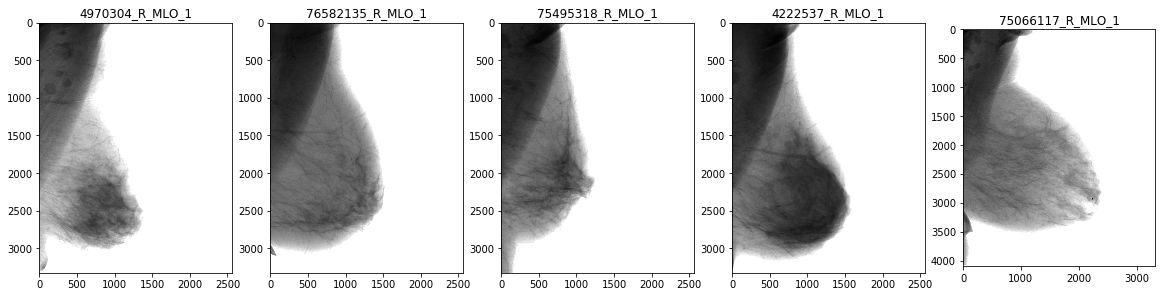

In [24]:
printFileList(list(a[a.BMI<31][:5]['filename'].values))

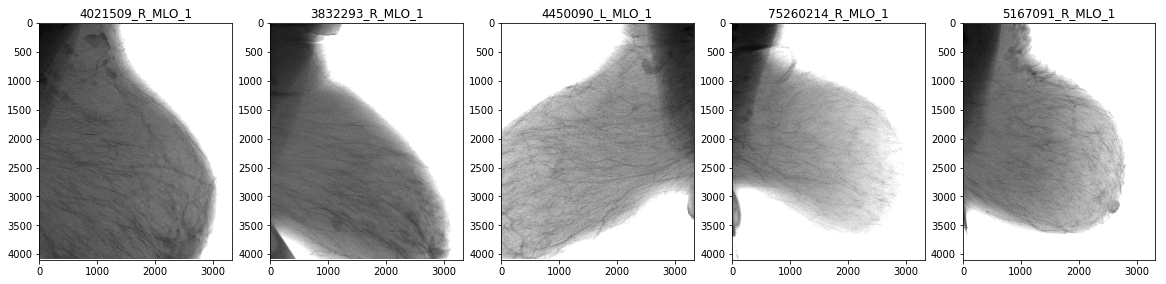

In [25]:
printFileList(list(a[a.BMI>41][:5]['filename'].values))

#### Feature 192 | All white

In [55]:
a = analyzeFeature(df,truth,192,250, (15,15), createPlots=False,return_df=True)

Race - White 1.0 | Side - R 0.49  | View - CC 0.01 


In [56]:
a = a.merge(temp, on='filename',how='left')

In [57]:
a.DenseAreaPercent.describe()

count    145.000000
mean      67.461525
std       20.343999
min       11.767900
25%       54.466400
50%       69.916500
75%       82.004900
max       99.875200
Name: DenseAreaPercent, dtype: float64

In [58]:
a[a.DenseAreaPercent<54][:5]

,filename,192,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
6,4687625_R_MLO_1,16.250347,4687625,R,MLO,White,3.0,6.9222,49.0313
7,4785015_L_MLO_1,15.862119,4785015,L,MLO,White,3.0,8.5779,52.2745
21,3081632_R_MLO_1,13.689811,3081632,R,MLO,White,2.0,9.5317,50.0555
24,3584357_L_MLO_1,13.285707,3584357,L,MLO,White,3.0,5.4910,41.3231
25,3584357_L_MLO_1,13.285707,3584357,L,MLO,White,3.0,5.4910,41.3231


In [59]:
a[a.DenseAreaPercent>82][:5]

,filename,192,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
16,75762328_R_MLO_1,14.413134,75762328,R,MLO,White,3.0,22.8353,91.0887
17,75762328_R_MLO_1,14.413134,75762328,R,MLO,White,3.0,22.8353,91.0887
31,75896588_L_MLO_1,13.109426,75896588,L,MLO,White,3.0,15.9926,87.0032
39,76912389_R_MLO_1,12.182814,76912389,R,MLO,White,3.0,22.9706,96.9487
40,76680905_R_MLO_1,12.165298,76680905,R,MLO,White,3.0,26.3231,96.6563


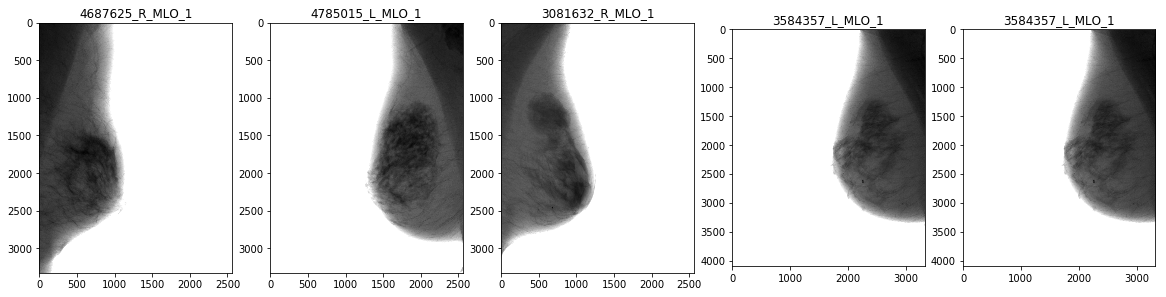

In [60]:
printFileList(list(a[a.DenseAreaPercent<54][:5]['filename'].values))

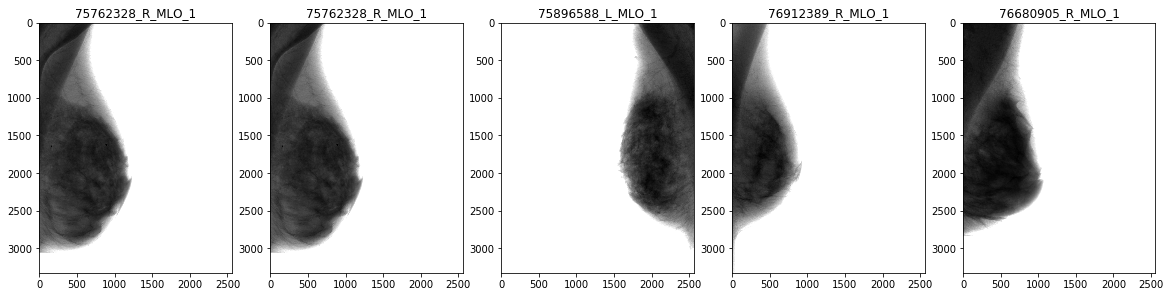

In [61]:
printFileList(list(a[a.DenseAreaPercent>82][:5]['filename'].values))

In [66]:
a[a.DenseAreaPercent<22][:5]

,filename,192,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
137,76879596_L_MLO_1,8.258739,76879596,L,MLO,White,2.0,3.3148,19.4390
170,3028168_L_MLO_1,7.779659,3028168,L,MLO,White,2.0,3.5845,12.4993
206,76254147_L_MLO_1,7.368682,76254147,L,MLO,White,2.0,3.5073,11.7679
207,76254147_L_MLO_1,7.368682,76254147,L,MLO,White,2.0,3.5073,11.7679
285,4075482_R_MLO_1,6.523594,4075482,R,MLO,White,2.0,3.6381,21.3120


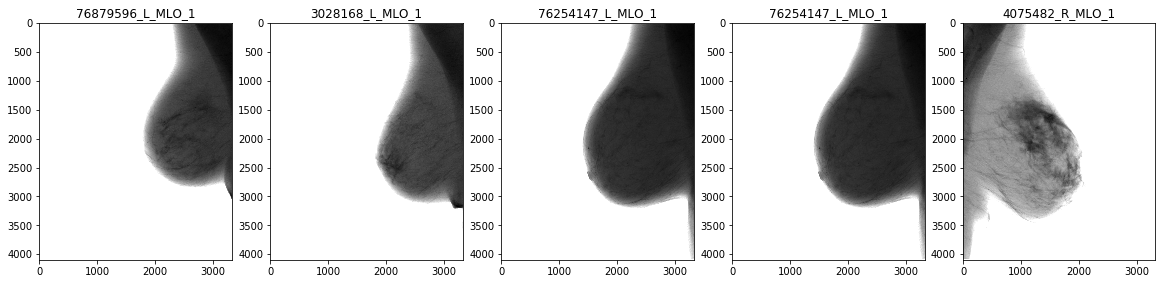

In [65]:
printFileList(list(a[a.DenseAreaPercent<22][:5]['filename'].values))

In [10]:
a = analyzeFeature(df,truth,192,1000, (15,15), createPlots=False,return_df=True)

a = a.merge(temp, on='filename',how='left')

Race - White 1.0 | Side - R 0.4  | View - CC 0.17 


In [11]:
a = a[~pd.isna(a.DenseAreaPercent)]

print(len(a))

509


In [12]:

np.corrcoef(a[192].values, a.DenseAreaPercent)

array([[1.      , 0.023834],
       [0.023834, 1.      ]])

In [22]:
a.head()

,filename,198,DummyID,Side,View,Medview_Race,Density_Overall,VolumetricBreastDensity,DenseAreaPercent
0,3768256_R_MLO_1,8.757934,3768256,R,MLO,African American,2.0,7.8008,67.58370
1,4021509_R_MLO_1,8.630558,4021509,R,MLO,African American,2.0,4.4200,8.09352
3,4337846_R_MLO_1,8.043472,4337846,R,MLO,African American,2.0,6.9252,57.15740
4,4276619_R_MLO_1,8.008749,4276619,R,MLO,African American,2.0,6.2010,38.06050
5,4970304_R_MLO_1,7.826849,4970304,R,MLO,African American,2.0,9.2228,66.16880


In [13]:
a = pd.merge(a, truth, on='DummyID',how='left')

a = a[~pd.isna(a.BMI)]

In [14]:

np.corrcoef(a[192].values, a.BMI)

array([[ 1.      , -0.045821],
       [-0.045821,  1.      ]])

## Modeling based on select features

In [81]:
selectFeats = ['filename',198,265,37,266,270,192,39,249,360,128]

trainData = df[selectFeats]
validData = validdf[selectFeats]



In [82]:
trainData['label'] = trainData.filename.apply(getRaceLabel)

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
validData['label'] = validData.filename.apply(getRaceLabel)

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
trainData.head()

,filename,198,265,37,266,270,192,39,249,360,128,label
0,75432702_FOR-PROCESSING_L_CC_1,-2.127386,-2.548289,-2.062002,-2.053010,-0.644143,4.024334,1.805459,3.075381,2.849386,5.024087,1
1,76172010_FOR-PROCESSING_R_CC_1,-0.633057,-1.611017,-1.400504,-1.670531,-1.153232,0.023437,0.454551,0.027588,1.401943,1.382586,1
2,3598763_FOR-PROCESSING_R_CC_1,-0.153099,-1.172739,-1.321008,-1.466827,-1.765290,-0.807362,0.526636,0.168446,1.790335,1.149157,1
3,5285183_L_MLO_1,1.895692,-1.035796,-0.024876,1.885191,1.622212,0.566305,-1.033908,0.948618,-1.092314,-1.325273,0
4,75216411_L_CC_1,1.290835,-0.398701,0.867882,1.015133,0.368733,0.054852,-1.369610,-0.734305,-0.182654,-0.324747,0


In [85]:
trainLabel = trainData.label
validLabel = validData.label

trainID =  trainData.filename
validID =  validData.filename

trainData.drop('label',axis =1, inplace = True)
validData.drop('label',axis =1, inplace = True)
trainData.drop('filename',axis =1, inplace = True)
validData.drop('filename',axis =1, inplace = True)



/home/santhosr/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [87]:
model = RandomForestClassifier()
model.fit(trainData, trainLabel)

/home/santhosr/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
pred = model.predict(validData)
accuracy_score(pred,validLabel)

0.829875

In [89]:
validLabel.value_counts()

1    4000
0    4000
Name: label, dtype: int64

In [90]:
roc_auc_score(pred,validLabel)

0.8300103248588375

In [91]:
validData['predLabel'] = pred

validData['filename'] = validID
trainData['filename'] = trainID

validData['DummyID'] = validData.filename.apply(lambda x : int(x.split("_")[0]))

truth = truth.drop_duplicates(subset='DummyID')
validData = pd.merge(validData, truth, on='DummyID',how='left')

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [92]:
len(validData)

8000

In [93]:
validData.head()

,198,265,37,266,270,192,39,249,360,128,predLabel,filename,DummyID,Age,BMI,Density_Overall,FolderLocation,Medview_Race,ScreenDate
0,-0.473801,-1.537895,-0.844898,-1.737964,-1.041735,0.140226,0.352662,-1.036287,0.936671,0.502077,1,76931196_FOR-PROCESSING_R_CC_1,76931196,55.7,27.8,3.0,/home/santhosr/Documents/Birad/ProcessedData/P...,White,12/19/2014
1,0.302574,-1.072293,-0.794957,-1.343741,-0.786048,-0.430960,-0.760093,-0.118034,1.489254,1.313534,1,3777048_FOR-PROCESSING_R_CC_1,3777048,62.9,20.1,3.0,/home/santhosr/Documents/Birad/ProcessedData/P...,White,7/15/2011
2,-0.800272,-0.259811,0.567094,-0.160846,0.202802,0.619998,-1.302152,-0.527975,-0.050566,-0.183191,0,75848706_L_CC_1,75848706,50.1,36.7,3.0,/home/santhosr/Documents/Birad/ProcessedData/F...,African American,12/6/2013
3,-2.764376,-1.691867,-2.225619,-0.776728,-1.119456,2.416416,3.062097,1.991664,0.229853,2.110430,1,75223618_FOR-PROCESSING_L_MLO_1,75223618,45.2,20.0,3.0,/home/santhosr/Documents/Birad/ProcessedData/P...,White,4/26/2013
4,1.466055,0.490276,1.191321,2.466757,1.876076,-0.544942,1.113976,-1.263506,-1.283029,-1.439235,0,5296539_L_MLO_1,5296539,73.1,27.5,2.0,/home/santhosr/Documents/Birad/ProcessedData/F...,African American,1/22/2013


In [94]:
validData['truthLabel'] = validData.filename.apply(getRaceLabel)

In [95]:
predDf = validData.copy()

In [96]:
outputData = []
for i in range(8):
    bmi_min,bmi_max = 15 + 5*i, 15 + 5*(i+1)
    
    subDf = predDf[predDf.BMI.between(bmi_min,bmi_max)]
    
    whiteDf = subDf[subDf.truthLabel==1]
    aaDf = subDf[subDf.truthLabel==0]
    
    selectSize = min(len(whiteDf), len(aaDf))
    
    whiteDf = whiteDf[:selectSize]
    aaDf = aaDf[:selectSize]
    
    tempDf = pd.concat([whiteDf, aaDf])
    
    whiteAcc = np.round(accuracy_score(whiteDf.truthLabel, whiteDf.predLabel),2)
    aaAcc = np.round(accuracy_score(aaDf.truthLabel, aaDf.predLabel),2)
    
    acc = np.round(accuracy_score(tempDf.truthLabel,tempDf.predLabel),2)
    
    outputData.append([bmi_min, bmi_max, selectSize, acc, whiteAcc,aaAcc])

    
tempDf = pd.DataFrame(outputData)
tempDf.columns = ['BMI_min','BMI_max','numImages','Total Acc','White Acc','Black Acc']

tempDf
    
    
    
    

,BMI_min,BMI_max,numImages,Total Acc,White Acc,Black Acc
0,15,20,88,0.78,0.88,0.68
1,20,25,472,0.78,0.87,0.70
2,25,30,1108,0.82,0.82,0.82
3,30,35,512,0.81,0.75,0.86
4,35,40,220,0.75,0.61,0.89
5,40,45,112,0.81,0.68,0.94
6,45,50,36,0.83,0.69,0.97
7,50,55,16,0.78,0.56,1.00


### FFT Analysis

In [8]:


def plot_spectrum(im_fft, figsize = (10,10)):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.figure(figsize = figsize)
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

img = getImageData('3511811_R_MLO_1')

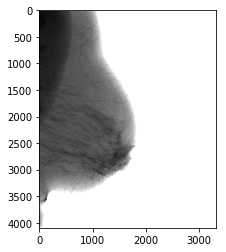

In [9]:
plotF

In [10]:
im_fft = fftpack.fft2(img)

In [13]:
im_fft.shape

(4096, 3328)

In [14]:
img.shape

(4096, 3328)

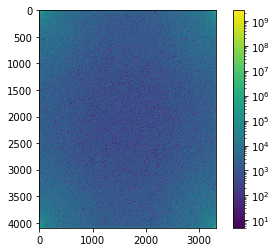

In [16]:
plot_spectrum(im_fft)

In [14]:
plotImageFFT('75425032_L_MLO_1',(10,10))



ValueError: Inccorrect filename